In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
# import keras_tuner
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from keras.applications.vgg16 import VGG16

#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

2024-04-11 19:13:02.792159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 19:13:04.297874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


we are currently using tensorflow version 2.13.0


In [2]:
train_dir = r'data/RiceLeafsDisease/train/'
test_dir = r'data/RiceLeafsDisease/validation/'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [3]:
BATCH_SIZE = 32
seeds = 41
im_shape = (250,250)

In [4]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


## VGG16

In [5]:
from tensorflow.keras.applications import VGG16

In [8]:
vgg_base = VGG16(  
    include_top=False,  
    weights='imagenet',  
    input_shape=(250, 250, 3),  
)  
    
vgg_base.trainable = False  

set_trainable = False  

for layer in vgg_base.layers:  
    if layer.name == 'block5_conv1':  
        set_trainable = True  
    if set_trainable:  
        layer.trainable = True  


vgg_model = Sequential()  
  
# 添加vgg_base模型  
vgg_model.add(vgg_base)  
  
# 添加Flatten层以将卷积层的输出展平  
vgg_model.add(Flatten())  
  
# 添加第一个全连接层，具有200个神经元和ReLU激活函数  
vgg_model.add(Dense(200, activation='relu'))  
  
# 添加输出层，具有6个神经元和softmax激活函数，假设有6个类别  
vgg_model.add(Dense(6, activation='softmax')) 


In [9]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 200)               5017800   
                                                                 
 dense_3 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 19733694 (75.28 MB)
Trainable params: 5019006 (19.15 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [10]:
#compiling 
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
import time
# Record the start time of training
start_time = time.time()

In [12]:
# Train the model
epochs = 20

early_stopping = EarlyStopping(  
    monitor='val_loss',  # 监控验证集损失  
    min_delta=0.0001,  # 监控指标改善的最小变化量  
    patience=5,  # 在多少个epoch内没有改善后停止训练  
    verbose=1,  # 日志打印模式  
    mode='auto',  # 监控指标是否应该被最小化或最大化，'auto'将根据指标名称决定  
    restore_best_weights=True  # 是否在训练停止后恢复最佳权重  
)  

checkpoint = ModelCheckpoint(  
    filepath='VGG16_model_20epochs.h5',  
    monitor='val_loss',  
    save_best_only=True,  
    verbose=1  
)  
  
# 将回调添加到列表中  
callbacks_list = [early_stopping, checkpoint]  

#Training
history = vgg_model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=epochs,
    callbacks = callbacks_list,
    validation_data=validation_generator,
    verbose = 1,
    validation_steps=nb_validation_samples // BATCH_SIZE) 

Epoch 1/20


2024-04-11 19:15:13.135895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-11 19:15:18.398759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-11 19:15:18.700557: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1ceb0840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-11 19:15:18.700772: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-11 19:15:18.863605: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-11 19:15:19.596008: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

52/52 [==============================] - ETA: 0s - loss: 1.6803 - accuracy: 0.5030
Epoch 1: val_loss improved from inf to 1.15181, saving model to VGG16_model_20epochs.h5
52/52 [==============================] - 51s 776ms/step - loss: 1.6803 - accuracy: 0.5030 - val_loss: 1.1518 - val_accuracy: 0.5841
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.8815 - accuracy: 0.6778
Epoch 2: val_loss improved from 1.15181 to 0.96800, saving model to VGG16_model_20epochs.h5
52/52 [==============================] - 42s 819ms/step - loss: 0.8815 - accuracy: 0.6778 - val_loss: 0.9680 - val_accuracy: 0.6226
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.7166
Epoch 3: val_loss improved from 0.96800 to 0.80834, saving model to VGG16_model_20epochs.h5
52/52 [==============================] - 43s 825ms/step - loss: 0.7433 - accuracy: 0.7166 - val_loss: 0.8083 - val_accuracy: 0.7043
Epoch 4/20
52/52 [==============================] - ETA: 0s -

In [13]:
# Record the training end time
end_time = time.time()

In [14]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 1400.0556313991547 seconds


In [15]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.680307,0.503034,1.151814,0.584135
1,0.881494,0.677791,0.967996,0.622596
2,0.743333,0.716626,0.808343,0.704327
3,0.649650,0.753641,0.706946,0.737981
4,0.565922,0.787015,0.704005,0.725962
5,0.532308,0.801578,0.684640,0.733173
6,0.513222,0.809466,0.753448,0.728365
7,0.453489,0.827670,0.587810,0.762019
8,0.436477,0.829490,0.623446,0.750000
9,0.416040,0.853155,0.574359,0.783654


In [16]:
import joblib

joblib.dump(history.history,'history_VGG.pkl')
history_CNN2 = joblib.load('history_VGG.pkl')

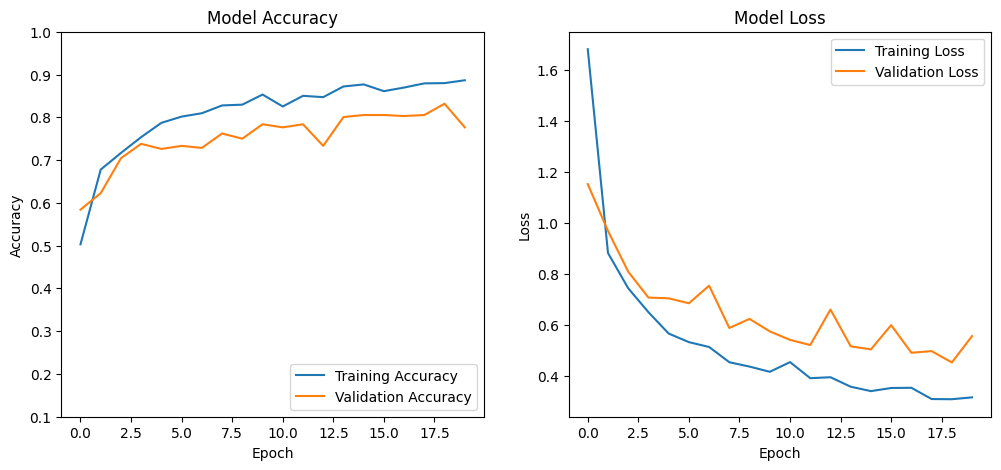

In [17]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_CNN2['accuracy'])
plt.plot(history_CNN2['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_CNN2['loss'])
plt.plot(history_CNN2['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')

plt.show()

In [17]:
# vgg_model.save('VGG16_model_20epochs.h5')

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


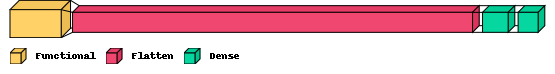

In [28]:
import visualkeras

visualkeras.layered_view(vgg_model,  legend=True)